## Demo for the Simulation of Interferometry Data and Time-Delay Interferometry
This demonstration introduces the basic concepts concerning the laser interferometry data of space-based GW detectors and time-delay interferometry, briefly showcasing the process from raw data to the product of TDI, which is further used for the analysis of GWs. The simulation in this demonstration does not include GW signals, but rather includes noise and other effects affecting the data. We use the "nominal" noise models in the current designs of space-based GW detectors, such that the results can be compared with theoretical predictions.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import logging

# To suppress the warning messages from lal
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

from Triangle.Constants import *
from Triangle.FFTTools import *
from Triangle.Noise import *
from Triangle.Orbit import *
from Triangle.Offset import *
from Triangle.Plot import *
from Triangle.Data import *
from Triangle.Interferometer import *
from Triangle.TDI import *
from Triangle.Glitch import * 

import matplotlib
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['font.family'] = 'serif'

## Set logging and multiprocessing

run this cell only ONCE

In [7]:
logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)

In [8]:
import multiprocessing
print('number of cpus =', multiprocessing.cpu_count())
pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())
# pool = None 

number of cpus = 32


## 1. Simulate interferometry data 

We give here a description of the "triangle" instrumental model, using the latest recommendations on conventions and notations established by the LISA Consortium (illustrated in the figure below).

<img src="Figures/constellation.png" alt="Drawing" style="width: 500px;">

Spacecraft are indexed 1, 2, 3 clockwise when looking down at their solar or earth-facing panels.  <!-- FIXME:earth-facing 这个措辞我也不知道对不对，反正目标就是日心地心都提及一下 -->
Any subsystem or measurement uniquely attached to a spacecraft is labelled with the same index. 
E.g., each spacecraft hosts a single clock.

For reference, a comprehensive list of acronyms used in the LISA (Laser Interferometer Space Antenna) mission can be found here:

- "Acronyms of the LISA mission": https://lisa.pages.in2p3.fr/consortium-userguide/LISA-LCST-MIS-LI-002_LISAAcronyms.pdf

---

<details>
<summary>What is MOSA?</summary>

In contrast to this, LISA is using two movable optical sub-assemblies (MOSAs) comprised of a test mass, an optical bench, and a telescope in each spacecraft. 
As shown in the figure (from [ArXiv:2201.10593](http://arxiv.org/abs/2201.10593)) as below.

<img src="Figures/MOSA.png" alt="Drawing" style="width: 500px;">

>"Movable" in this context refers to rotation around an axis perpendicular to the plane defined by both
MOSAs, which is required to compensate for the seasonal changes in the angle in the plane of the
constellation between the two adjacent line-of-sights. (from https://lisa.nasa.gov/archive2011/Documentation/LISA-MSE-DD-0001_v1.1.pdf#page=15.55)

As illustrated in the figure below, each spacecraft hosts two optical benches. 
We usually refer to one optical bench as the local optical bench; the other optical bench hosted by the same spacecraft as the adjacent optical bench; 
we call the distant optical bench the one situated on the spacecraft exchanging light with the local optical bench. 
Each optical bench is associated with a laser source, a gravitational reference sensor (GRS) containing a free-falling test mass, and telescope to send and collect light to and from distant spacecraft.

Laser beams are combined in 3 different heterodyne interferometers. 
The interspacecraft interferometer (ISI) mixes the local beam with the distant beam (coming from the distant optical bench); 
the test-mass interferometer (TMI) mixes the local and adjacent beams, after it has bounced on the local test mass;
and the reference interferometer (RFI) mixes the local and adjacent beams without interaction with the test mass.
Figure below gives an overview of the optical bench 12 (from [ArXiv:2212.05351](http://arxiv.org/abs/2212.05351)).

<img src="Figures/MOSA2.png" alt="Drawing" style="width: 500px;">



</details>

Each movable optical sub-assembly (MOSA, including an optical bench, a telescope, and a gravitaional reference sensor hosting the test-mass, etc.) is labeled by $ij$ ($ij \in \{12, 23, 31, 21, 32, 13\}$), with $i$ being the index of spacecraft (SC) carrying this MOSA, and $j$ the index of distant SC that transmits lasers with this MOSA. 
6 laser interferometric measurements are taken on ${\rm MOSA}_{ij}$:  
- inter-spacecraft (scientific) interferometer (ISI), carrier ${\rm ISI}_{c, ij}$
- inter-spacecraft (scientific) interferometer (ISI), sideband ${\rm ISI}_{sb, ij}$
- test-mass interferometer (TMI), carrier ${\rm TMI}_{c, ij}$
- test-mass interferometer (TMI), sideband ${\rm TMI}_{sb, ij}$
- reference interferometer (RFI), carrier ${\rm RFI}_{c, ij}$
- reference interferometer (RFI), sideband ${\rm RFI}_{sb, ij}$

The results of laser interferometry are read out by the phasemeters (learn more from [X](https://hdl.handle.net/2014/40283), [X](https://www.phys.ufl.edu/research/lisa/phasemeter.shtml) and [X](https://pdfs.semanticscholar.org/9ba9/8ad7de58a07628d7847a960ea644378e71b9.pdf)), which output the instantanous frequencies of interferometric measurements, therefore all the 6 $\times$ 6 data streams are simulated in  the frequency (Hz) unit.

<details>
<summary>Why frequency not phase?</summary>

>See https://arxiv.org/pdf/2212.05351#page=4.07

</details>

Each interferometric data stream is a time series uniformly spaced in time, including a $\sim$ MHz order slow-varying "offset" part (the ``out-of-band`` part), and a $\sim {\rm Hz}$ order jittering "fluctuation" part (the ``in-band`` part). 
The former can be affected by the laser locking schemes, the frequency plans, the doppler effects due to orbital motions, etc., and the latter includes various noises and GW signals. 
Note that this is only an artificial division and in realistic detection we only have access to the sum of them. The separation of these two parts is only possible after a "detrending" process.

<details>
<summary>Why decomposed?</summary>

>See https://arxiv.org/pdf/2212.05351#page=4.33
</details>


### 1.1 Simulate the ``out-of-band`` part

#### data settings 

In [36]:
fsample = 1 / 10000 # use a (unrealistic) low sampling frequency since this part is slow-varying 
data_time = 110 * 4 * DAY #110 * DAY
ifo_drop_time1 = 0 # data at the beginning and end are invalid due to interpolation. to remove these data points, we can either use the "drop_time" setting of the simulator, or drop these data by hand.
ifo_drop_time2 = 0
tdi_drop_time1 = 0
tdi_drop_time2 = 0
size = int((data_time + ifo_drop_time1 + ifo_drop_time2 + tdi_drop_time1 + tdi_drop_time2) * fsample)
interp_order = 15 # use a relative low order of interpolation 

#### initialize the models of orbit, noises and clock drifts

<!-- FIXME: 是不是可以对照着 https://pypi.org/project/lisaorbits/ 的代码来优化和丰富我们的 Orbit 呢 -->

In [42]:
# initialize orbit model from orbit data file 
# orbit = Orbit(OrbitDir='OrbitData/MicroSateOrbitEclipticTCB', dt=DAY, tstart=0, pn_order=2) 
orbit = Orbit(OrbitDir='OrbitData/LISALikeOrbitEclipticTCB/20280322_LISA_2p5Mkm', dt=DAY, tstart=0, pn_order=2) # 2.5Mkm 
# dt is the sampling interval of orbit data file
# set tstart = t0 (in second) to start simulation from orbit time t0
# pn_order = twice the PN order used to calculate inter-spacecraft light travel time 

# set the slow-varying drifts of laser frequencies and clocks
offset = OffsetFunctions(laser_flag=False, clock_flag=False) 

# initialize basic instrumental noises 
noise = InstrumentalPSDs(unit='ffd') 

In [43]:
ifo = Interferometers(
    size=size,
    fsample=fsample,
    time_frame='ProperTime', # the time frame of data, 'ProperTime' for the proper times of SCs, 'ClockTime' for the times of on-board clocks (with clock drifts and jitters relative to the proper times) 
    garbage_time1=ifo_drop_time1, # remove invalid data at the beginning 
    garbage_time2=ifo_drop_time2, # remove invalid data at the end 
    telemetry_downsample=None, # downsampling factor = f_before / f_after 
    detrend_order=None, # order of polynomial used to detrend. detrending with polynomial is only suitable for short-duration data. 
    acc_noise=False, # switch of acceleration noise
    ro_noise=False, # switch of readout noise (all types of ifos)
    laser_noise=False, # switch of laser frequency noise 
    clock_noise=False, # switch of clock noise (also need to set time_frame = 'ClockTime')
    ob_noise=False, # switch of optical bench displacement noise 
    bl_noise=False, # switch of fibre backlink noise 
    op_noise=False, # switch of optical path noise (all optical paths)
    ranging_noise=False, # switch of pseudo ranging noise 
    modulation_noise=False, # switch of sideband modulation noise 
    orbit_class=orbit,
    offset_class=offset,
    noise_class=noise,
    gw_class=None,
    fplan=fplan, # set laser locking scheme and frequency plan 
    order=interp_order, # order of lagrange interpolation used to calculate time delays, 31 for noisy data and lower for offset-only or GW-only data 
    pool=pool,
    clean_memory=True, # whether to clean some intermediate variables to save memory 
    )

# simulate interferometric measurements 
ifo.SimulateInterferometers()

# save data to a dictionary 
m = ifo.OutputMeasurements(mode='decomposed') 
# different modes to save data: 
# decomposed: output the in-band (e.g. sci_c, sci_sb, ...) and out-of-band part (e.g. a is the out-of-band part for sci_c, b is the out-of-band part for ref_c, ...) separately, namely assuming perfect detrending;
# total: output the total data;
# detrended: output the in-band and out-of-band parts, assuming polynomial detrending;
# telemetry_total: downsampled total data, same as "total" if telemetry_downsample=None;
# telemetry_detrended: downsampled in-band and out-of-band parts, , same as "detrended" if telemetry_downsample=None. 

ifo.clean() 

# convert the time frame of data to TCB, which is a global frame used in GW data analysis.
# this simulates the "clock synchronization" processe, assuming that the clock drifts can be pefectly measured and corrected. 
m1 = TPStoTCB(m, orbit_class=orbit, order=interp_order, pool=pool) 
m1.keys()

INFO:Triangle.Interferometer:Simulating data with sampling frequency 0.0001 Hz.
INFO:Triangle.Interferometer:size = 12614
INFO:Triangle.Interferometer:Set frequency plan.
INFO:Triangle.Interferometer:time frame is ProperTime
INFO:Triangle.Interferometer:Noise types:
INFO:Triangle.Interferometer:No GW signal.
INFO:Triangle.Interferometer:Generating basic instrumental noises.
INFO:Triangle.Interferometer:Basic instrumental noises generated.
INFO:Triangle.Interferometer:Generating proper times.
INFO:Triangle.Interferometer:Proper time generated.
INFO:Triangle.Interferometer:Generating proper delays.
INFO:Triangle.Interferometer:Proper delays generated.
INFO:Triangle.Interferometer:Generating clock offsets.
INFO:Triangle.Interferometer:Clock offsets generated.
INFO:Triangle.Interferometer:Generating unlocked sources.
INFO:Triangle.Interferometer:unlocked sources generated.
INFO:Triangle.Interferometer:Generating locked sources.
INFO:Triangle.Interferometer:Locked sources generated.
INFO:Tr

dict_keys(['time', 'fsample', 'ltt', 'sci_c', 'sci_sb', 'ref_c', 'ref_sb', 'tm_c', 'a', 'b'])

#### visualize light travel times 
also known as "delays" or "arm lengths"

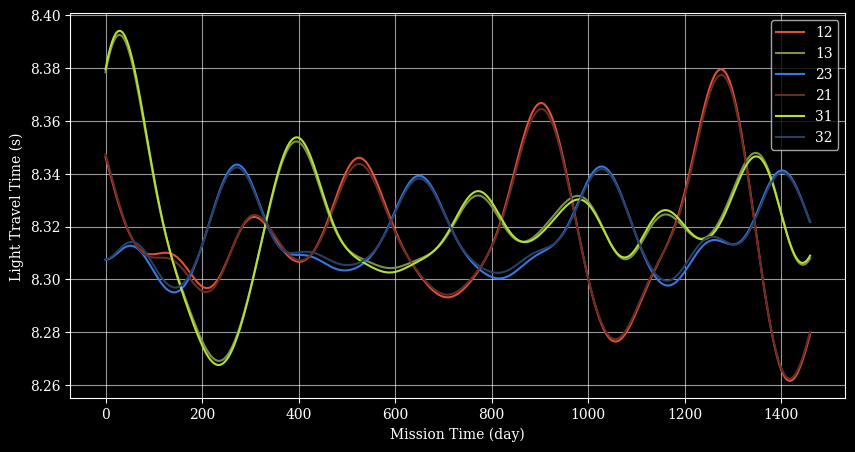

In [44]:
plt.figure(figsize=(10, 5))
for key in MOSA_labels:
    plt.plot(m1['time'][key[0]] / DAY, m1['ltt'][key], color=MOSA_colors[key], label=key)
plt.grid(which='major', alpha=0.6)
plt.xlabel('Mission Time (day)')
plt.ylabel('Light Travel Time (s)')
plt.legend()

#### visualize doppler $\dot{d}_{ij}$

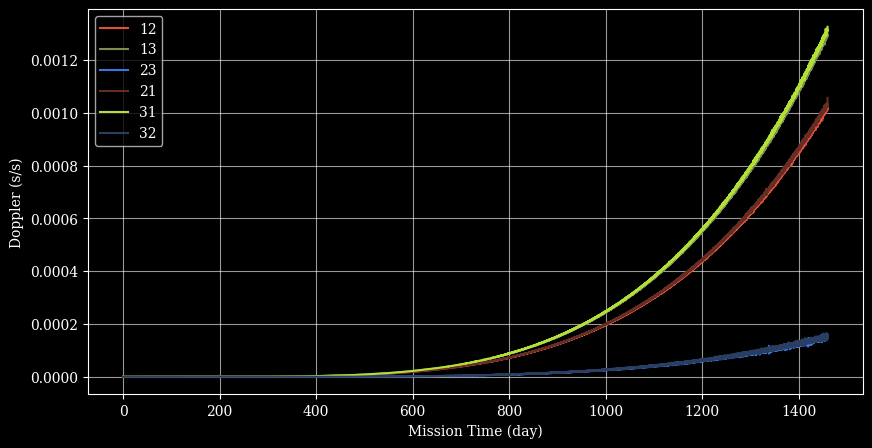

In [40]:
dpl = m1['ltt'].derivative(fsample) 
plt.figure(figsize=(10, 5))
for key in MOSA_labels:
    plt.plot(m1['time'][key[0]] / DAY, dpl[key], color=MOSA_colors[key], label=key)
plt.grid(which='major', alpha=0.6)
plt.xlabel('Mission Time (day)')
plt.ylabel('Doppler (s/s)')
plt.legend()

#### visualize the out-of-band ${\rm MHz}$ part
here we only show the carrier of inter-spacecraft interferometer (sci_c). 

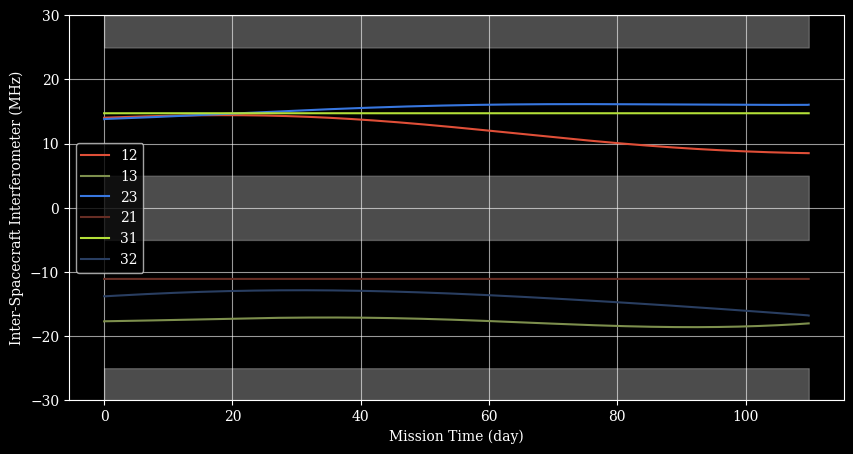

In [21]:
plt.figure(figsize=(10, 5))
for key in MOSA_labels:
    plt.plot(m1['time'][key[0]] / DAY, m1['a'][key] / 1e6, color=MOSA_colors[key], label=key)
plt.fill_between(m1['time'][key[0]] / DAY, 25, 30, color='grey', alpha=0.6)
plt.fill_between(m1['time'][key[0]] / DAY, -30, -25, color='grey', alpha=0.6)
plt.fill_between(m1['time'][key[0]] / DAY, -5, 5, color='grey', alpha=0.6)
plt.grid(which='major', alpha=0.6)
plt.xlabel('Mission Time (day)')
plt.ylabel('Inter-Spacecraft Interferometer (MHz)')
plt.ylim(-30, 30)
plt.legend()

### 1.2 Simulate the ``in-band`` part 
We simulate the in-band part of data, considering the main noise sources:

the "primary" noises (will be suppressed by TDI): 
- laser frequency noise
- clock noise 
- optical bench displacement noise 

the "secondary" noises:
- readout noise (including shot noise and others)
- test-mass acceleration noise

In [22]:
fsample = 10
data_time = 1 * DAY 
ifo_drop_time1 = 100 # data at the beginning and end may be invalid (due to interpolation) and should be removed, usually 100s should be enough. 
ifo_drop_time2 = 100
tdi_drop_time1 = 100
tdi_drop_time2 = 100 
size = int((data_time + ifo_drop_time1 + ifo_drop_time2 + tdi_drop_time1 + tdi_drop_time2) * fsample)
interp_order = 31 

In [23]:
orbit = Orbit(OrbitDir='OrbitData/MicroSateOrbitEclipticTCB', tstart=10.*DAY) # here we start from the 10th day of orbit 
offset = OffsetFunctions(laser_flag=False, clock_flag=False) # no clock drifts
noise = InstrumentalPSDs(unit='ffd') 

In [24]:
ifo = Interferometers(
    size=size,
    fsample=fsample,
    time_frame='ClockTime', # this time clock noise is included, so we set time_frame = 'ClockTime' and clock_noise = True
    garbage_time1=ifo_drop_time1, 
    garbage_time2=ifo_drop_time2,
    telemetry_downsample=None, 
    detrend_order=None, 
    acc_noise=True,
    ro_noise=True, 
    laser_noise=True, 
    clock_noise=True, 
    ob_noise=True,
    bl_noise=False, 
    op_noise=False, 
    ranging_noise=False, 
    modulation_noise=False,
    orbit_class=orbit,
    offset_class=offset,
    noise_class=noise,
    gw_class=None,
    fplan=fplan,
    order=interp_order, 
    pool=pool,
    clean_memory=True, 
    )

ifo.SimulateInterferometers()
m = ifo.OutputMeasurements(mode='decomposed') # we assume perfect detrending
ifo.clean()

m1 = TPStoTCB(m, orbit_class=orbit, order=interp_order, pool=pool) # Note that this function only deals with the clock drifts. The clock noises will be reserved in the data and needs to be reduced with TDI.
m1.keys()

INFO:Triangle.Interferometer:Simulating data with sampling frequency 10 Hz.
INFO:Triangle.Interferometer:size = 868000
INFO:Triangle.Interferometer:Set frequency plan.
INFO:Triangle.Interferometer:time frame is ClockTime
INFO:Triangle.Interferometer:Noise types:
INFO:Triangle.Interferometer:	acc_noise
INFO:Triangle.Interferometer:	ro_sci_c_noise
INFO:Triangle.Interferometer:	ro_sci_sb_noise
INFO:Triangle.Interferometer:	ro_ref_c_noise
INFO:Triangle.Interferometer:	ro_ref_sb_noise
INFO:Triangle.Interferometer:	ro_tm_c_noise
INFO:Triangle.Interferometer:	laser_noise
INFO:Triangle.Interferometer:	ob_noise
INFO:Triangle.Interferometer:	clock_noise
INFO:Triangle.Interferometer:No GW signal.
INFO:Triangle.Interferometer:Generating basic instrumental noises.
INFO:Triangle.Interferometer:Basic instrumental noises generated.
INFO:Triangle.Interferometer:Generating proper times.
INFO:Triangle.Interferometer:Proper time generated.
INFO:Triangle.Interferometer:Generating proper delays.
INFO:Triang

dict_keys(['time', 'fsample', 'ltt', 'sci_c', 'sci_sb', 'ref_c', 'ref_sb', 'tm_c', 'a', 'b'])

#### plot ASDs of the inter-spacecraft interferometers
for the fiducial locking scheme, 2 of them are used for phase locking, and others are dominated by laser frequency noises.

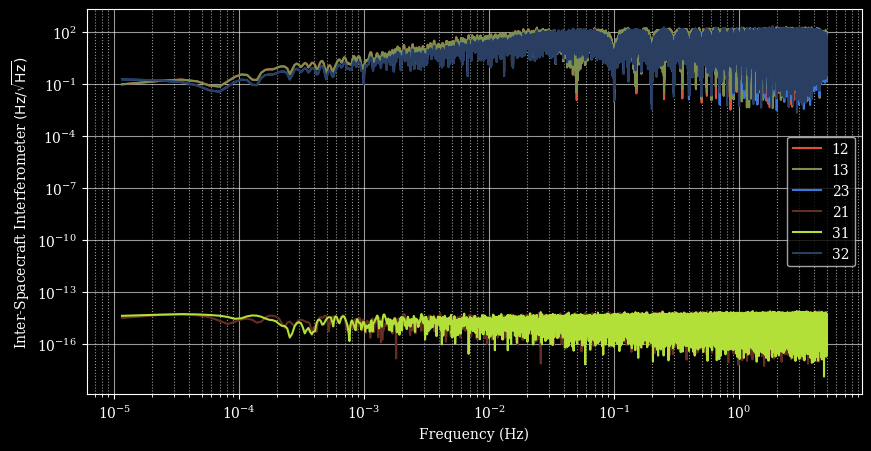

In [25]:
win = 'kaiser'
windict = dict(beta=28)
nbin = 1

plt.figure(figsize=(10, 5))
for key in MOSA_labels:
    f, xf = PSD_window(m1['sci_c'][key], m1['fsample'], nbin=nbin, window_type=win, window_args_dict=windict)
    plt.loglog(f, np.sqrt(xf), color=MOSA_colors[key], label=key)

plt.grid(which='major', alpha=0.6)
plt.grid(which='minor', alpha=0.6, linestyle=':')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Inter-Spacecraft Interferometer ' + r'${\rm (Hz/\sqrt{Hz})}$')

plt.legend()

## 2. Simulate time-delay interferometry (TDI) processing 
The complete TDI processing includes 4 steps: 
- construct the intermediate variable $\xi_{ij}$ which are free of optical bench displacement noise
- construct the intermediate varibale $\eta_{ij}$ to reduce half of the laser noises 
- combine TDI channel to reduce all the laser noises. This step differs for different TDI schemes (e.g. Michelson type $\{X, Y, Z\}$, Sagnac type $\{\alpha, \beta, \gamma\}$)
- calculate and subtract the clock noise correction term 

Note that prior to TDI processing, the "delays" should be obtained from a “ranging“ process that measures the inter-spacecraft light travel times $d_{ij}$ (denoting laser propagating from SC j to SC i), and the traditional TDI algorithm also requires that all measurements to be "synchronized" to a global time frame. Here we assume perfect ranging and synchronization to TCB. 

For TDI processing with the frequency unit, one should use the "doppler" delay operator 
$$\dot{\boldsymbol{\rm D}}_{ij} f\ \equiv \left(1 - \dot{d}_{ij}\right) \boldsymbol{\rm D}_{ij} f$$
where 
$$\bm{\rm D}_{ij}f(t) \equiv f\left(t - d_{ij}\right)$$

The inputs of this demo are generated by the last demo (1.2). 

In [26]:
# initialize TDI with the input data  
tdi = TDI(measurements=m1, delays=m1['ltt'], fsample=m1['fsample'], order=31, delay_order=5)
# order: used to specify the order of Lagrange interpolation used to delay the data streams 
# delay order: the interpolation order used to calculate nested delay time, should be low since delays are slow-varyging 

# calculate \xi_ij
tdi.CalculateXi(doppler=True, pool=pool)
# doppler: decides whether to use the doppler delay operator 

# calculate \eta_ij 
tdi.CalculateEta(doppler=True)

# combine the 2nd generation Michelson X TDI channels 
tdi.CalculateBasicTDI(channel='X2', doppler=True)

tdi.measurements.keys()

INFO:Triangle.TDI:TDI channel X2 calculated.


dict_keys(['time', 'fsample', 'ltt', 'sci_c', 'sci_sb', 'ref_c', 'ref_sb', 'tm_c', 'a', 'b', 'dpl', 'xi', 'eta', 'X2'])

In [27]:
# calculate the clock noise correction term 
tdi.CalculateClockTDI(channel='X2', modulation_correction=False, channel_name='X2')

tdi.measurements.keys()

INFO:Triangle.TDI:clock correction for channel X2 calculated.


dict_keys(['time', 'fsample', 'ltt', 'sci_c', 'sci_sb', 'ref_c', 'ref_sb', 'tm_c', 'a', 'b', 'dpl', 'xi', 'eta', 'X2', 'X2_q'])

#### compare the raw data, TDI channel before / after clock noise reduction 
interpolation error will dominate half order of magnitude near the Nyquist frequency 

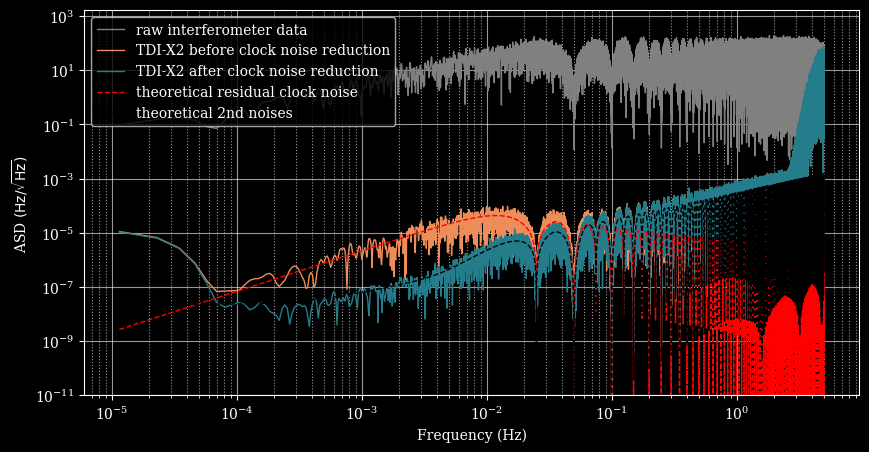

In [28]:
# get arm lengths to calculate the theoretical noise PSDs (use arm lengths at the median time should be sufficient for a short-duration data)
arms = dict()
arm_idx = int(len(m1['ltt']['12']) / 2.)
for k, v in m1['ltt'].items():
    arms[k] = v[arm_idx]

win = 'kaiser'
windict = dict(beta=28)
nbin = 1
drop1 = int(tdi_drop_time1 * fsample) # drop the invalid data at the beginning 
drop2 = -int(tdi_drop_time2 * fsample) # drop the invalid data at the end 

plt.figure(figsize=(10, 5))

f, xf = PSD_window(m1['sci_c']['12'], m['fsample'], nbin=nbin, window_type=win, window_args_dict=windict)
plt.loglog(f, np.sqrt(xf), color='grey', linewidth=1, label='raw interferometer data')

f, xf = PSD_window(tdi.measurements['X2'][drop1:drop2], tdi.fsample, nbin=nbin, window_type=win, window_args_dict=windict)
plt.loglog(f, np.sqrt(xf), color=ORANGE, linewidth=1, label='TDI-X2 before clock noise reduction')

f, xf = PSD_window((tdi.measurements['X2'] - tdi.measurements['X2_q'])[drop1:drop2], tdi.fsample, nbin=nbin, window_type=win, window_args_dict=windict)
plt.loglog(f, np.sqrt(xf), color=GREEN1, linewidth=1, label='TDI-X2 after clock noise reduction')

plt.loglog(f, np.sqrt(ResidualClockNoise(freqs=f, a=tdi.measurements["a"], b=tdi.measurements["b"], channel="X2")), color='red', linestyle="--", label="theoretical residual clock noise", linewidth=1)

PSD = TDIPSDs()
PSD_X2 = PSD.PSD_X2_unequal(f, arms) # this function returns noise PSD in the fractional frequency difference unit 
plt.loglog(f, np.sqrt(PSD_X2) * F_LASER, color='k', linestyle='--', linewidth=1, label ='theoretical 2nd noises')

plt.grid(which='major', alpha=0.6)
plt.grid(which='minor', alpha=0.6, linestyle=':')

plt.ylim(1e-11, )

plt.xlabel('Frequency (Hz)')
plt.ylabel('ASD ' + r'${\rm (Hz/\sqrt{Hz})}$')

plt.legend(loc='upper left')

## 3. Simulate a more complete TDI processing 
- simulate the total interferometry data (not detrended)
- include clock dirfts 
- include sideband modulation noise 
- ranging and synchronization processing using a simple implementation of the "TDI without synchronization" algorithm [PhysRevD.105.122008]

### 3.1 simulate interferometry data 

In [30]:
fsample = 10
data_time = 1 * DAY 
ifo_drop_time1 = 100 # data at the beginning and end may be invalid (due to interpolation) and should be removed. 
ifo_drop_time2 = 100
tdi_drop_time1 = 100
tdi_drop_time2 = 100 
size = int((data_time + ifo_drop_time1 + ifo_drop_time2 + tdi_drop_time1 + tdi_drop_time2) * fsample)
interp_order = 31

In [31]:
orbit = Orbit(OrbitDir='OrbitData/MicroSateOrbitEclipticTCB', tstart=10.*DAY) # here we start from the 10th day of orbit 
offset = OffsetFunctions(laser_flag=False, clock_flag=True) # clock drifts set 
noise = InstrumentalPSDs(unit='ffd') 

In [32]:
ifo = Interferometers(
    size=size,
    fsample=fsample,
    time_frame='ClockTime',
    garbage_time1=ifo_drop_time1, 
    garbage_time2=ifo_drop_time2,
    telemetry_downsample=None, 
    detrend_order=None, 
    acc_noise=True,
    ro_noise=True, 
    laser_noise=True, 
    clock_noise=True, 
    ob_noise=True,
    bl_noise=False, 
    op_noise=False, 
    ranging_noise=True, # simulate pseudo ranging with noise 
    modulation_noise=True,
    orbit_class=orbit,
    offset_class=offset,
    noise_class=noise,
    gw_class=None,
    fplan=fplan,
    order=interp_order, 
    pool=pool,
    clean_memory=True, 
    )

ifo.SimulateInterferometers()
m = ifo.OutputMeasurements(mode='total') # the raw data is neither detrended nor synchronized 
ifo.clean()

m.keys()

INFO:Triangle.Interferometer:Simulating data with sampling frequency 10 Hz.
INFO:Triangle.Interferometer:size = 868000
INFO:Triangle.Interferometer:Set frequency plan.
INFO:Triangle.Interferometer:time frame is ClockTime
INFO:Triangle.Interferometer:Noise types:
INFO:Triangle.Interferometer:	acc_noise
INFO:Triangle.Interferometer:	ro_sci_c_noise
INFO:Triangle.Interferometer:	ro_sci_sb_noise
INFO:Triangle.Interferometer:	ro_ref_c_noise
INFO:Triangle.Interferometer:	ro_ref_sb_noise
INFO:Triangle.Interferometer:	ro_tm_c_noise
INFO:Triangle.Interferometer:	laser_noise
INFO:Triangle.Interferometer:	ob_noise
INFO:Triangle.Interferometer:	clock_noise
INFO:Triangle.Interferometer:	ranging_noise
INFO:Triangle.Interferometer:	modulation_noise
INFO:Triangle.Interferometer:No GW signal.
INFO:Triangle.Interferometer:Generating basic instrumental noises.
INFO:Triangle.Interferometer:Basic instrumental noises generated.
INFO:Triangle.Interferometer:Generating proper times.
INFO:Triangle.Interferomete

dict_keys(['sci_c', 'sci_sb', 'ref_c', 'ref_sb', 'tm_c', 'a', 'b', 'mpr', 'ppr', 'fsample', 'time'])

#### plot total interferometry data 

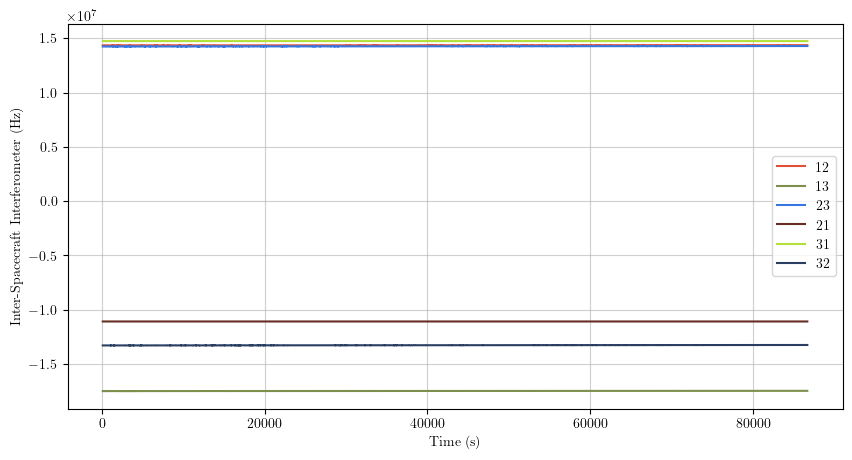

In [33]:
plt.figure(figsize=(10, 5))
for key in MOSA_labels:
    plt.plot(m['time'][key[0]], m['sci_c'][key], color=MOSA_colors[key], label=key)

plt.grid(which='major', alpha=0.6)
plt.xlabel('Time (s)')
plt.ylabel('Inter-Spacecraft Interferometer (Hz)')

plt.legend()

#### plot ranges 
here we show 2 types of ranges ("delays"):
- proper pseudo ranges: proper time of receiving laser - proper time of sending laser
- measured pseudo ranges: clock time of receiving laser - clock time of sending laser, which is what we actually measure with pseudo random noise codes (assuming no ambiguity and bias), and what we will used in the next step. 


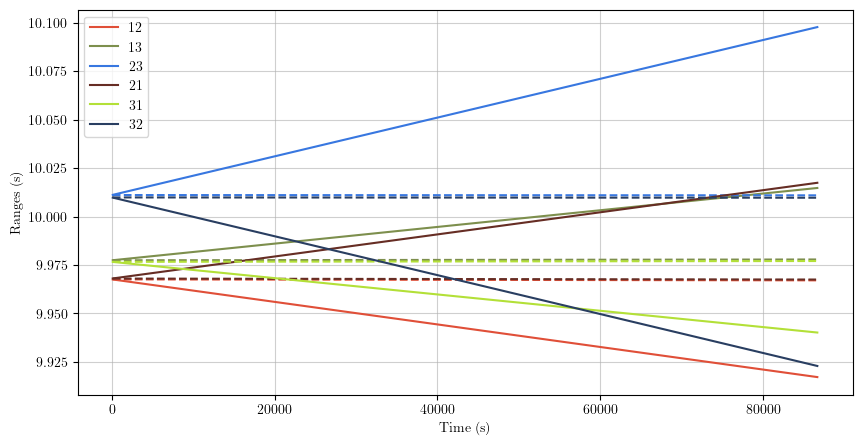

In [34]:
plt.figure(figsize=(10, 5))
for key in MOSA_labels:
    plt.plot(m['time'][key[0]], m['mpr'][key], color=MOSA_colors[key], label=key)
    plt.plot(m['time'][key[0]], m['ppr'][key], color=MOSA_colors[key], linestyle="--")

plt.grid(which='major', alpha=0.6)
plt.xlabel('Time (s)')
plt.ylabel('Ranges (s)')

plt.legend()

### 3.2 ranging processing 
combine PRN and sideband to get high-precision inter-spacecraft ranges that can be used in TDI, high-precision dopplers are also calculated.

In [35]:
m1 = RangingProcessing(m, modulation_correction=True, doppler=True)
m1.keys()

dict_keys(['sci_c', 'sci_sb', 'ref_c', 'ref_sb', 'tm_c', 'a', 'b', 'mpr', 'ppr', 'fsample', 'time', 'dpl'])

#### compare the ranges before / after processing 

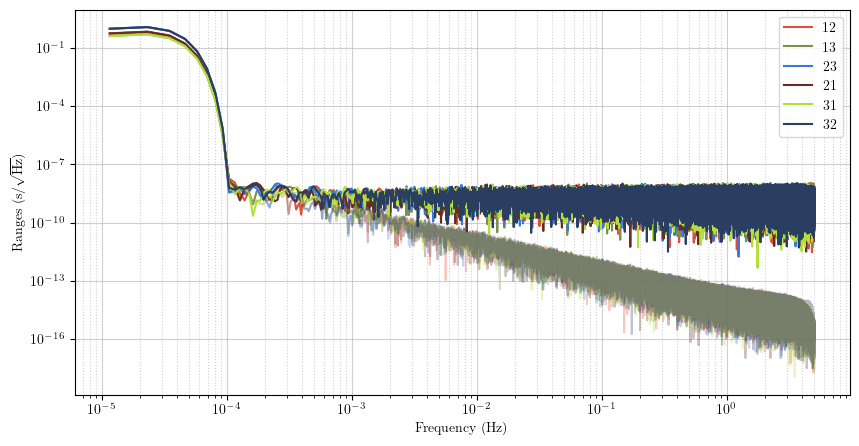

In [36]:
win = 'kaiser'
windict = dict(beta=28)
nbin = 1

plt.figure(figsize=(10, 5))
for key in MOSA_labels:
    f, xf = PSD_window(m['mpr'][key], m['fsample'], nbin=nbin, window_type=win, window_args_dict=windict)
    plt.loglog(f, np.sqrt(xf), color=MOSA_colors[key], label=key)
    
    f, xf = PSD_window(m1['mpr'][key], m1['fsample'], nbin=nbin, window_type=win, window_args_dict=windict)
    plt.loglog(f, np.sqrt(xf), color=MOSA_colors[key], alpha=0.3)

plt.grid(which='major', alpha=0.6)
plt.grid(which='minor', alpha=0.6, linestyle=':')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Ranges ' + r'${\rm (s/\sqrt{Hz})}$')

plt.legend()

#### compare the dopplers before / after processing 

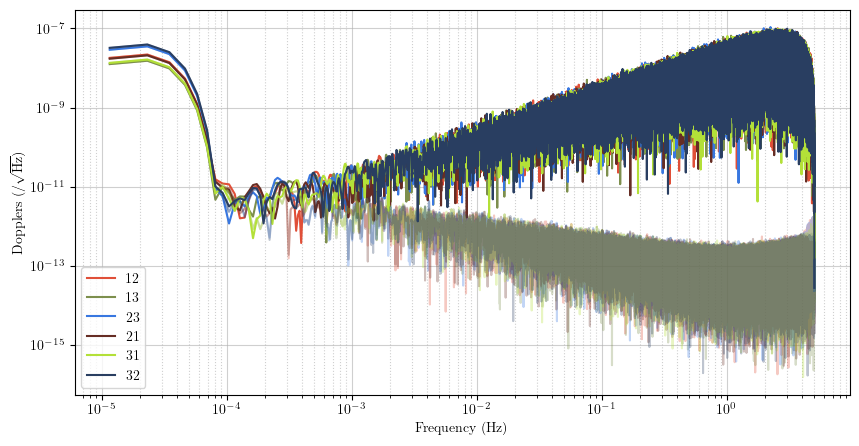

In [37]:
win = 'kaiser'
windict = dict(beta=28)
nbin = 1

dpl = m['mpr'].derivative(m['fsample'])
plt.figure(figsize=(10, 5))
for key in MOSA_labels:
    f, xf = PSD_window(dpl[key], m['fsample'], nbin=nbin, window_type=win, window_args_dict=windict)
    plt.loglog(f, np.sqrt(xf), color=MOSA_colors[key], label=key)
    
    f, xf = PSD_window(m1['dpl'][key], m1['fsample'], nbin=nbin, window_type=win, window_args_dict=windict)
    plt.loglog(f, np.sqrt(xf), color=MOSA_colors[key], alpha=0.3)

plt.grid(which='major', alpha=0.6)
plt.grid(which='minor', alpha=0.6, linestyle=':')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Dopplers ' + r'${\rm (/\sqrt{Hz})}$')

plt.legend()

### 3.3 TDI processing 
In this TDI scheme, the clock deviations (both drifts and jitters) are dealt with during the combination of TDI channels, therefore there is no more clock noise reduction step after TDI. 

2 key differences from the traditional TDI scheme: 
- use the total interferometry data instead of the detrended ones. 
- use the PRN ranges instead of the light travel times 

Note that the time frame of the resulting TDI data is the clock time of spacecraft 1 (for X2 channel), and further synchronizing to TCB is still required. 

In [38]:
tdi = TDI(measurements=m1, delays=m1['mpr'], fsample=m1['fsample'], order=31, delay_order=5)
tdi.CalculateXi(pool=pool, doppler=True)
tdi.CalculateEta(doppler=True)
tdi.CalculateBasicTDI(channel='X2', doppler=True)
tdi.measurements.keys()

INFO:Triangle.TDI:TDI channel X2 calculated.


dict_keys(['sci_c', 'sci_sb', 'ref_c', 'ref_sb', 'tm_c', 'a', 'b', 'mpr', 'ppr', 'fsample', 'time', 'dpl', 'xi', 'eta', 'X2'])

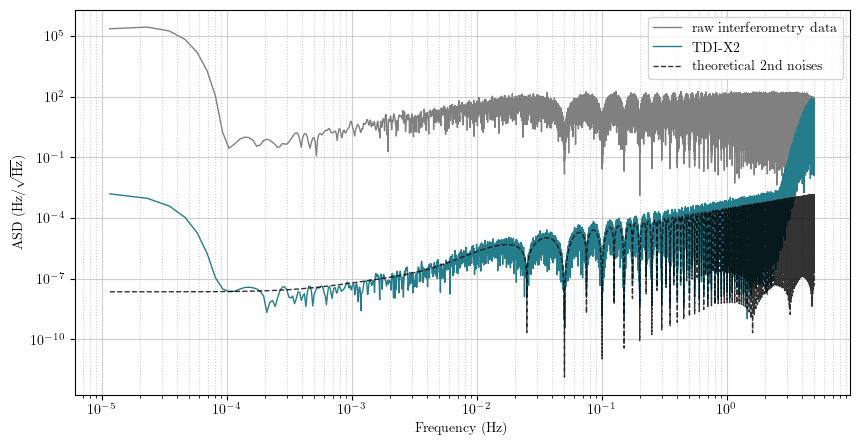

In [39]:
win = 'kaiser'
windict = dict(beta=28)
nbin = 1
drop1 = int(tdi_drop_time1 * fsample)
drop2 = -int(tdi_drop_time2 * fsample)

plt.figure(figsize=(10, 5))

f, xf = PSD_window(m1['sci_c']["12"], m1['fsample'], nbin=nbin, window_type=win, window_args_dict=windict)
plt.loglog(f, np.sqrt(xf), color="grey", label='raw interferometry data', linewidth=1)

f, xf = PSD_window(tdi.measurements['X2'][drop1:drop2], tdi.fsample, nbin=nbin, window_type=win, window_args_dict=windict)
plt.loglog(f, np.sqrt(xf), color=GREEN1, label='TDI-X2', linewidth=1)

PSD = TDIPSDs()
PSD_X2 = PSD.PSD_X2_unequal(f, arms)
plt.loglog(f, np.sqrt(PSD_X2) * F_LASER, color='k', linestyle='--', alpha=0.8, linewidth=1, label = 'theoretical 2nd noises')

plt.grid(which='major', alpha=0.6)
plt.grid(which='minor', alpha=0.6, linestyle=':')

plt.xlabel('Frequency (Hz)')
plt.ylabel('ASD ' + r'${\rm (Hz/\sqrt{Hz})}$')

plt.legend()


## 4. More advanced simulations

### 4.1 vary noise amplitudes for different MOSAs 
Simulate a secondary-noise-only data, but the noise amplitudes are different for different MOSAs.

Other noises in the ifo.BasicNoise dictionary can also be modified. 

In [40]:
fsample = 10
data_time = 1 * DAY 
ifo_drop_time1 = 100 
ifo_drop_time2 = 100
tdi_drop_time1 = 100
tdi_drop_time2 = 100 
size = int((data_time + ifo_drop_time1 + ifo_drop_time2 + tdi_drop_time1 + tdi_drop_time2) * fsample)
interp_order = 31

orbit = Orbit(OrbitDir='OrbitData/MicroSateOrbitEclipticTCB', tstart=10.*DAY) 
offset = OffsetFunctions(laser_flag=False, clock_flag=False) 
noise = InstrumentalPSDs(unit='ffd') 

ifo = Interferometers(
    size=size,
    fsample=fsample,
    time_frame='ProperTime',
    garbage_time1=ifo_drop_time1, 
    garbage_time2=ifo_drop_time2,
    telemetry_downsample=None, 
    detrend_order=None, 
    acc_noise=True,
    ro_noise=True, 
    laser_noise=False, 
    clock_noise=False, 
    ob_noise=False,
    bl_noise=False, 
    op_noise=False, 
    ranging_noise=False, 
    modulation_noise=False,
    orbit_class=orbit,
    offset_class=offset,
    noise_class=noise,
    gw_class=None,
    fplan=fplan,
    order=interp_order, 
    pool=pool,
    clean_memory=False, 
    )

# break the ifo.SimulateInterferometer() function into steps so that we can modify the intermediate variables 
ifo.SimulateBasicNoise()

# modify the amplitudes of acceleration noises 
for key in MOSA_labels:
    ifo.BasicNoise['ro_sci_c_noise'][key] *= np.random.uniform(1.5, 2.5)  
    
ifo.SimulateRangeAndClock()
if ifo.gw_flag:
    ifo.SimulateGW()
ifo.SimulateMeasurements()
m = ifo.OutputMeasurements(mode='decomposed')

m1 = TPStoTCB(m, orbit_class=orbit, order=interp_order, pool=pool) 

tdi = TDI(measurements=m1, delays=m1['ltt'], fsample=m1['fsample'], order=31, delay_order=5)
tdi.CalculateXi(doppler=True, pool=pool)
tdi.CalculateEta(doppler=True)
tdi.CalculateBasicTDI(channel='X2', doppler=True)

tdi.measurements.keys()

INFO:Triangle.Interferometer:Simulating data with sampling frequency 10 Hz.
INFO:Triangle.Interferometer:size = 868000
INFO:Triangle.Interferometer:Set frequency plan.
INFO:Triangle.Interferometer:time frame is ProperTime
INFO:Triangle.Interferometer:Noise types:
INFO:Triangle.Interferometer:	acc_noise
INFO:Triangle.Interferometer:	ro_sci_c_noise
INFO:Triangle.Interferometer:	ro_sci_sb_noise
INFO:Triangle.Interferometer:	ro_ref_c_noise
INFO:Triangle.Interferometer:	ro_ref_sb_noise
INFO:Triangle.Interferometer:	ro_tm_c_noise
INFO:Triangle.Interferometer:No GW signal.
INFO:Triangle.Interferometer:Generating basic instrumental noises.
INFO:Triangle.Interferometer:Basic instrumental noises generated.
INFO:Triangle.Interferometer:Generating proper times.
INFO:Triangle.Interferometer:Proper time generated.
INFO:Triangle.Interferometer:Generating proper delays.
INFO:Triangle.Interferometer:Proper delays generated.
INFO:Triangle.Interferometer:Generating clock offsets.
INFO:Triangle.Interferom

dict_keys(['time', 'fsample', 'ltt', 'sci_c', 'sci_sb', 'ref_c', 'ref_sb', 'tm_c', 'a', 'b', 'dpl', 'xi', 'eta', 'X2'])

#### plot the ASD of TDI 
the results are different from the nominal noise level due to the aforementioned modification. 

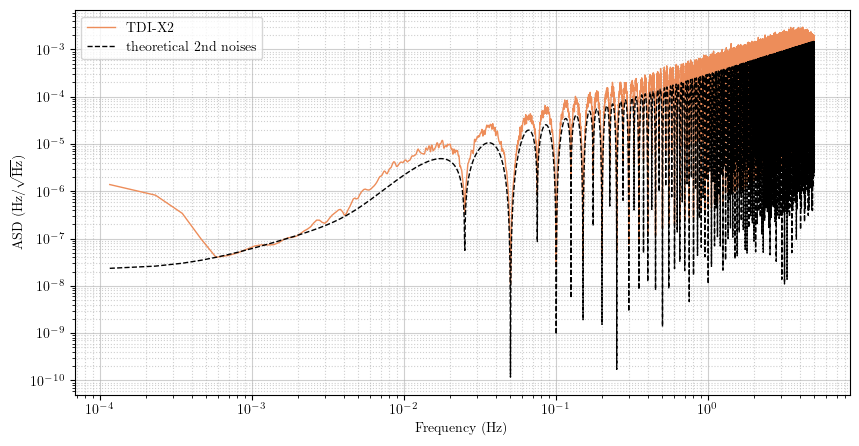

In [41]:
arms = dict()
arm_idx = int(len(m1['ltt']['12']) / 2.)
for k, v in m1['ltt'].items():
    arms[k] = v[arm_idx]

win = 'kaiser'
windict = dict(beta=28)
nbin = 10 # NOTE: calculate average PSD to show the shape more clearly 
drop1 = int(tdi_drop_time1 * fsample) 
drop2 = -int(tdi_drop_time2 * fsample) 

plt.figure(figsize=(10, 5))

f, xf = PSD_window(tdi.measurements['X2'][drop1:drop2], tdi.fsample, nbin=nbin, window_type=win, window_args_dict=windict)
plt.loglog(f, np.sqrt(xf), color=ORANGE, linewidth=1, label='TDI-X2')

PSD = TDIPSDs()
PSD_X2 = PSD.PSD_X2_unequal(f, arms) 
plt.loglog(f, np.sqrt(PSD_X2) * F_LASER, color='k', linestyle='--', linewidth=1, label = 'theoretical 2nd noises') # theoetidal noise PSD based on the "nominal" noise amplitudes 

plt.grid(which='major', alpha=0.6)
plt.grid(which='minor', alpha=0.6, linestyle=':')

plt.xlabel('Frequency (Hz)')
plt.ylabel('ASD ' + r'${\rm (Hz/\sqrt{Hz})}$')

plt.legend(loc='upper left')


### 4.2 Glitch injection 
Simulate a glitch-only data. A "LPF legacy" glitch is injected to test-mass 12. 

In [42]:
fsample = 10 
data_time = 1 * DAY 
ifo_drop_time1 = 100 
ifo_drop_time2 = 100
tdi_drop_time1 = 100
tdi_drop_time2 = 100 
size = int((data_time + ifo_drop_time1 + ifo_drop_time2 + tdi_drop_time1 + tdi_drop_time2) * fsample)
interp_order = 31

orbit = Orbit(OrbitDir='OrbitData/MicroSateOrbitEclipticTCB', tstart=10.*DAY) 
offset = OffsetFunctions(laser_flag=False, clock_flag=False) 
noise = InstrumentalPSDs(unit='ffd') 

ifo = Interferometers(
    size=size,
    fsample=fsample,
    time_frame='ProperTime',
    garbage_time1=ifo_drop_time1, 
    garbage_time2=ifo_drop_time2,
    telemetry_downsample=None, 
    detrend_order=None, 
    acc_noise=True, # create the interface of test-mass glitch 
    ro_noise=False, 
    laser_noise=False, 
    clock_noise=False, 
    ob_noise=False,
    bl_noise=False, 
    op_noise=False, 
    ranging_noise=False, 
    modulation_noise=False,
    orbit_class=orbit,
    offset_class=offset,
    noise_class=noise,
    gw_class=None,
    fplan=fplan,
    order=interp_order, 
    pool=pool,
    clean_memory=False, 
    )

ifo.SimulateBasicNoise()
ifo.SimulateRangeAndClock()

# add glitch to the acceleration noise 
glitch = Glitch(fsample=ifo.fsample)
glitch_simulation_time = ifo.proper_time['1'] # generate glitch according to the proper time of spacecraft 1 
glitch_injection_time = 30000. # set injection time 
short_glitch_acc = glitch.LPF_legacy_glitch_model(t=glitch_simulation_time, t0=glitch_injection_time, **glitch.short_glitch_kwargs) # generate glitch in the acceleration unit 
short_glitch_ffd = glitch.acc2ffd(short_glitch_acc) # convert to the fractional frequency difference unit 
for key in MOSA_labels: 
    ifo.BasicNoise['acc_noise'][key] *= 0. # clean acceleration noises 
ifo.BasicNoise['acc_noise']['12'] = short_glitch_ffd # inject glitch 

if ifo.gw_flag:
    ifo.SimulateGW()
ifo.SimulateMeasurements()
m = ifo.OutputMeasurements(mode='decomposed')

m1 = TPStoTCB(m, orbit_class=orbit, order=interp_order, pool=pool) 

tdi = TDI(measurements=m1, delays=m1['ltt'], fsample=m1['fsample'], order=31, delay_order=5)
tdi.CalculateXi(doppler=True, pool=pool)
tdi.CalculateEta(doppler=True)
tdi.CalculateBasicTDI(channel='X2', doppler=True)

tdi.measurements.keys()

INFO:Triangle.Interferometer:Simulating data with sampling frequency 10 Hz.
INFO:Triangle.Interferometer:size = 868000
INFO:Triangle.Interferometer:Set frequency plan.
INFO:Triangle.Interferometer:time frame is ProperTime
INFO:Triangle.Interferometer:Noise types:
INFO:Triangle.Interferometer:	acc_noise
INFO:Triangle.Interferometer:No GW signal.
INFO:Triangle.Interferometer:Generating basic instrumental noises.
INFO:Triangle.Interferometer:Basic instrumental noises generated.
INFO:Triangle.Interferometer:Generating proper times.
INFO:Triangle.Interferometer:Proper time generated.
INFO:Triangle.Interferometer:Generating proper delays.
INFO:Triangle.Interferometer:Proper delays generated.
INFO:Triangle.Interferometer:Generating clock offsets.
INFO:Triangle.Interferometer:Clock offsets generated.
INFO:Triangle.Interferometer:Generating unlocked sources.
INFO:Triangle.Interferometer:unlocked sources generated.
INFO:Triangle.Interferometer:Generating locked sources.
INFO:Triangle.Interferome

dict_keys(['time', 'fsample', 'ltt', 'sci_c', 'sci_sb', 'ref_c', 'ref_sb', 'tm_c', 'a', 'b', 'dpl', 'xi', 'eta', 'X2'])

#### visualize glitch in the TDI channel 

Text(0, 0.5, 'Glitch in TDI X2')

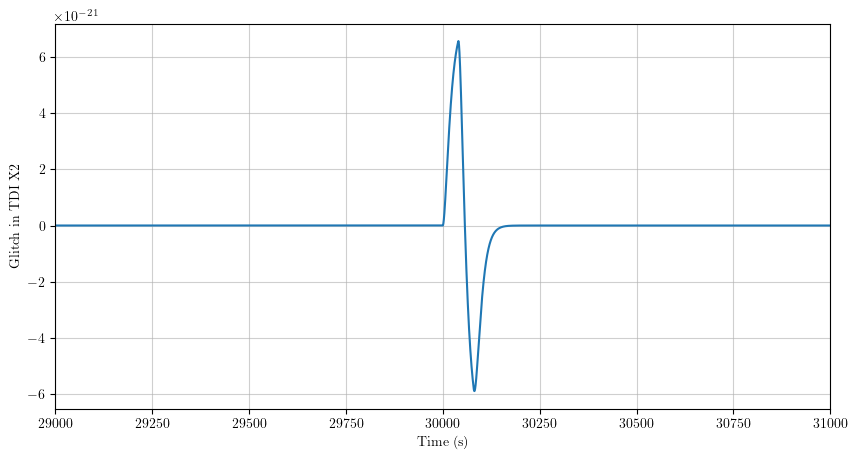

In [43]:
drop1 = int(tdi_drop_time1 * fsample)
drop2 = -int(tdi_drop_time2 * fsample)

plt.figure(figsize=(10, 5))

plt.plot(tdi.measurements['time']['1'][drop1:drop2], tdi.measurements['X2'][drop1:drop2] / F_LASER) # convert to fractional frequency difference unit 

plt.grid(which='major', alpha=0.6)
plt.grid(which='minor', alpha=0.6, linestyle=':')

plt.xlim(glitch_injection_time - 1000, glitch_injection_time+1000)

plt.xlabel('Time (s)')
plt.ylabel('Glitch in TDI X2')

## 5. Custom TDI combinations 
Custom TDI combinations can be constructed in 4 ways: 
- by channel name, only valid for "X_1", "X_2", "alpha_1", "alpha_2"; 
- by a faster implementation of the Michelson channels;
- by strings specifying the synthesized optical paths, e.g. ['121313121', '131212131'] stands for the "X_2" channel, with the 1st string being the path with plus sign, and the 2nd being the path with minus sign;
- by strings specifying the $\boldsymbol{\rm P}_{ij}$ operators so that ${\rm TDI} = \sum_{ij} \boldsymbol{\rm P}_{ij} \eta_{ij}$. This method is the slowest, but can be applied to the widest range of TDI channels. e.g. For the 2nd-generation Michelson X channel, the $P_{ij}$ operators are: 
\begin{align}
    \textbf{P}_{12} &= -1 + \textbf{D}_{131} + \textbf{D}_{13121} - \textbf{D}_{1213131}, \nonumber \\ 
    \textbf{P}_{23} &= 0, \nonumber \\ 
    \textbf{P}_{31} &= \textbf{D}_{13} - \textbf{D}_{1213} - \textbf{D}_{121313} + \textbf{D}_{13121213}, \nonumber \\ 
    \textbf{P}_{21} &= -\textbf{D}_{12} + \textbf{D}_{1312} + \textbf{D}_{131212} - \textbf{D}_{12131312}, \nonumber \\ 
    \textbf{P}_{32} &= 0, \nonumber \\ 
    \textbf{P}_{13} &= 1 - \textbf{D}_{121} - \textbf{D}_{12131} + \textbf{D}_{1312121}.  
\end{align}
which can be specified by the following strings: 

In [44]:
X2_string = {
    "12": [(-1., []), (1., ["13", "31"]), (1., ["13", "31", "12", "21"]), (-1., ["12", "21", "13", "31", "13", "31"])], 
    "23": [], 
    "31": [(1., ["13"]), (-1., ["12", "21", "13"]), (-1., ["12", "21", "13", "31", "13"]), (1., ["13", "31", "12", "21", "12", "21", "13"])], 
    "21": [(-1., ["12"]), (1., ["13", "31", "12"]), (1., ["13", "31", "12", "21", "12"]), (-1., ["12", "21", "13", "31", "13", "31", "12"])], 
    "32": [], 
    "13": [(1., []), (-1., ["12", "21"]), (-1., ["12", "21", "13", "31"]), (1., ["13", "31", "12", "21", "12", "21"])], 
}

#### simulate interferometer data 

In [45]:
fsample = 10
data_time = 1 * DAY 
ifo_drop_time1 = 100 # data at the beginning and end may be invalid (due to interpolation) and should be removed. 
ifo_drop_time2 = 100
tdi_drop_time1 = 100
tdi_drop_time2 = 100 
size = int((data_time + ifo_drop_time1 + ifo_drop_time2 + tdi_drop_time1 + tdi_drop_time2) * fsample)
interp_order = 31

orbit = Orbit(OrbitDir='OrbitData/MicroSateOrbitEclipticTCB', tstart=10.*DAY) # here we start from the 10th day of orbit 
offset = OffsetFunctions(laser_flag=False, clock_flag=False) # no clock drifts
noise = InstrumentalPSDs(unit='ffd') 

ifo = Interferometers(
    size=size,
    fsample=fsample,
    time_frame='ProperTime',
    garbage_time1=ifo_drop_time1, 
    garbage_time2=ifo_drop_time2,
    telemetry_downsample=None, 
    detrend_order=None, 
    acc_noise=True,
    ro_noise=True, 
    laser_noise=True, 
    clock_noise=False, 
    ob_noise=False,
    bl_noise=False, 
    op_noise=False, 
    ranging_noise=False, 
    modulation_noise=False,
    orbit_class=orbit,
    offset_class=offset,
    noise_class=noise,
    gw_class=None,
    fplan=fplan,
    order=interp_order, 
    pool=pool,
    clean_memory=True, 
    )

ifo.SimulateInterferometers()
m = ifo.OutputMeasurements(mode='decomposed') 
ifo.clean()

m1 = TPStoTCB(m, orbit_class=orbit, order=interp_order, pool=pool) 
m1.keys()

INFO:Triangle.Interferometer:Simulating data with sampling frequency 10 Hz.
INFO:Triangle.Interferometer:size = 868000
INFO:Triangle.Interferometer:Set frequency plan.
INFO:Triangle.Interferometer:time frame is ProperTime
INFO:Triangle.Interferometer:Noise types:
INFO:Triangle.Interferometer:	acc_noise
INFO:Triangle.Interferometer:	ro_sci_c_noise
INFO:Triangle.Interferometer:	ro_sci_sb_noise
INFO:Triangle.Interferometer:	ro_ref_c_noise
INFO:Triangle.Interferometer:	ro_ref_sb_noise
INFO:Triangle.Interferometer:	ro_tm_c_noise
INFO:Triangle.Interferometer:	laser_noise
INFO:Triangle.Interferometer:No GW signal.
INFO:Triangle.Interferometer:Generating basic instrumental noises.
INFO:Triangle.Interferometer:Basic instrumental noises generated.
INFO:Triangle.Interferometer:Generating proper times.
INFO:Triangle.Interferometer:Proper time generated.
INFO:Triangle.Interferometer:Generating proper delays.
INFO:Triangle.Interferometer:Proper delays generated.
INFO:Triangle.Interferometer:Generati

dict_keys(['time', 'fsample', 'ltt', 'sci_c', 'sci_sb', 'ref_c', 'ref_sb', 'tm_c', 'a', 'b'])

#### calculate X2 channel in 4 ways and compare

In [46]:
tdi = TDI(measurements=m1, delays=m1['ltt'], fsample=m1['fsample'], order=31, delay_order=5)
tdi.CalculateXi(doppler=True, pool=pool)
tdi.CalculateEta(doppler=True)

# 1)
tdi.CalculateBasicTDI(channel='X2', doppler=True)
X2_method1 = tdi.measurements['X2'].copy()

# 2)
tdi.FastMichelson(doppler=True, channel='X') # channel can be 'X', 'XYZ' or 'AET'
X2_method2 = tdi.measurements['X2'].copy()

# 3) 
tdi.CalculateBasicTDI(channel=['121313121', '131212131'], doppler=True, channel_name='X2')
X2_method3 = tdi.measurements['X2'].copy()

# 4) 
X2_method4 = tdi.CalculateTDIFromPStrings(X2_string, doppler=True)
X2_method4 *= -1. # the P operators shown above are different from the other 3 methods by a minus sign. 

INFO:Triangle.TDI:TDI channel X2 calculated.
INFO:Triangle.TDI:TDI channel X2 calculated.


#### illustrate the consistency among methods 

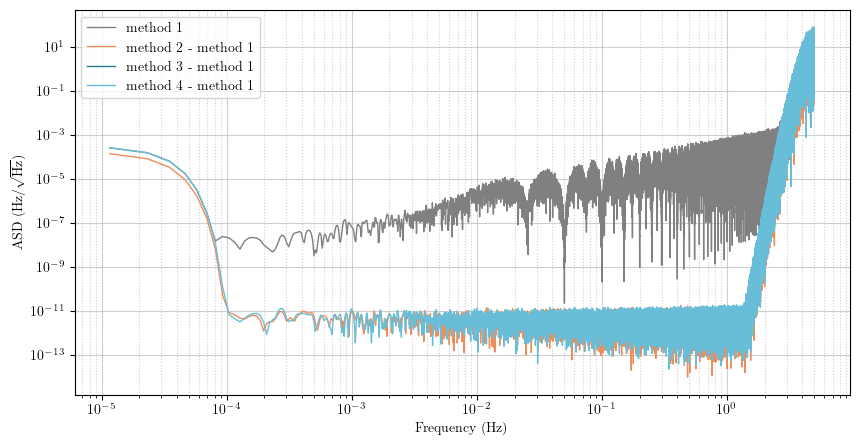

In [47]:
win = 'kaiser'
windict = dict(beta=28)
nbin = 1
drop1 = int(tdi_drop_time1 * fsample) 
drop2 = -int(tdi_drop_time2 * fsample) 

plt.figure(figsize=(10, 5))

f, xf = PSD_window(X2_method1[drop1:drop2], tdi.fsample, nbin=nbin, window_type=win, window_args_dict=windict)
plt.loglog(f, np.sqrt(xf), color="grey", linewidth=1, label='method 1')

f, xf = PSD_window((X2_method2 - X2_method1)[drop1:drop2], tdi.fsample, nbin=nbin, window_type=win, window_args_dict=windict)
plt.loglog(f, np.sqrt(xf), color=ORANGE, linewidth=1, label='method 2 - method 1')

f, xf = PSD_window((X2_method3 - X2_method1)[drop1:drop2], tdi.fsample, nbin=nbin, window_type=win, window_args_dict=windict)
plt.loglog(f, np.sqrt(xf), color=GREEN1, linewidth=1, label='method 3 - method 1') # equal to 0 hence not shown in the figure 

f, xf = PSD_window((X2_method4 - X2_method1)[drop1:drop2], tdi.fsample, nbin=nbin, window_type=win, window_args_dict=windict) 
plt.loglog(f, np.sqrt(xf), color=BLUE, linewidth=1, label='method 4 - method 1') 

plt.grid(which='major', alpha=0.6)
plt.grid(which='minor', alpha=0.6, linestyle=':')

plt.xlabel('Frequency (Hz)')
plt.ylabel('ASD ' + r'${\rm (Hz/\sqrt{Hz})}$')

plt.legend(loc='upper left')
